# Statistical Methods Project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# EDA (data description, data preprocessing)

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/ov3ipo/SM_Project/main/life_expectancy.csv")
# remove trailing space in columns name and format display function
pd.options.display.float_format = '{:.4f}'.format
df = df.rename(columns=lambda x: x.strip())

# overview on data statistic
display(df.head(10))
display(df.info())

# get quantitative and qualitative data
numeric_cols = df.drop(columns=["Status", "Country"], axis=1).columns

10 rows × 22 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

None

## Data description

### Univariate

#### Qualitative

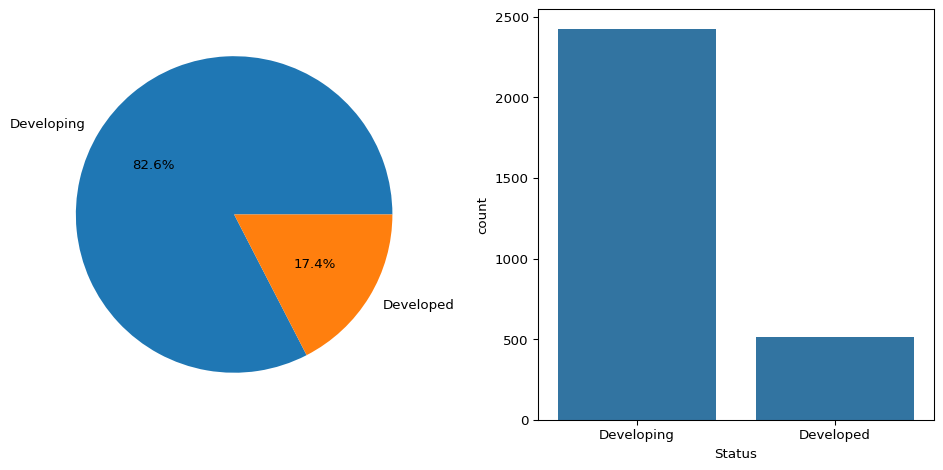

In [3]:
plt.figure(figsize = (10,5))
plt.subplot(1, 2, 1)
x = df['Status'].value_counts().reset_index()
plt.pie(x=x['count'], labels=x['Status'], autopct="%0.1f%%")
plt.subplot(1, 2, 2)
sns.countplot(df, x="Status")
plt.tight_layout()
plt.show()

``` {markdown}
Remark:
- Why didn't we consider the Country col in this case?
- State what you see in the chart
```

#### Quantitative

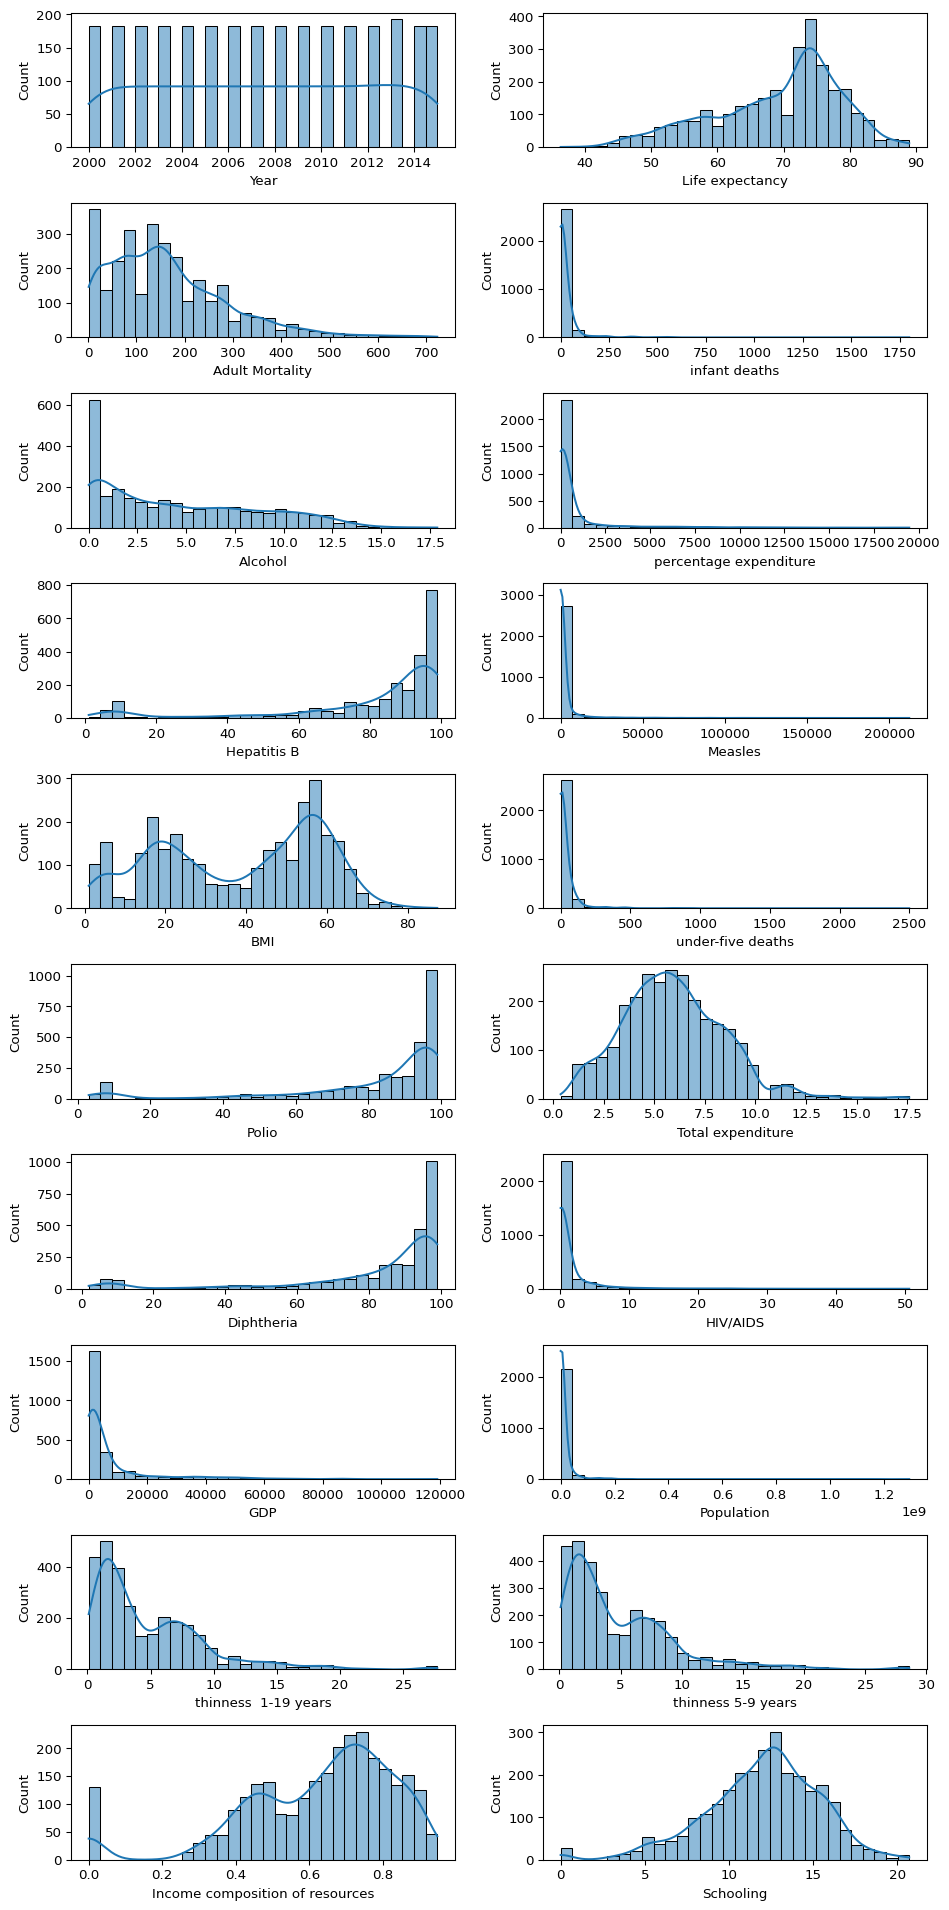

In [4]:
plt.figure(figsize=(10, 20))
for i, col in enumerate(numeric_cols):
    plt.subplot(10, 2, i + 1)
    sns.histplot(df, x=col, bins=30, kde=True)
plt.tight_layout()
plt.show()

``` {markdown}
Remark:
- State what you see in the chart
```

### Bivariate

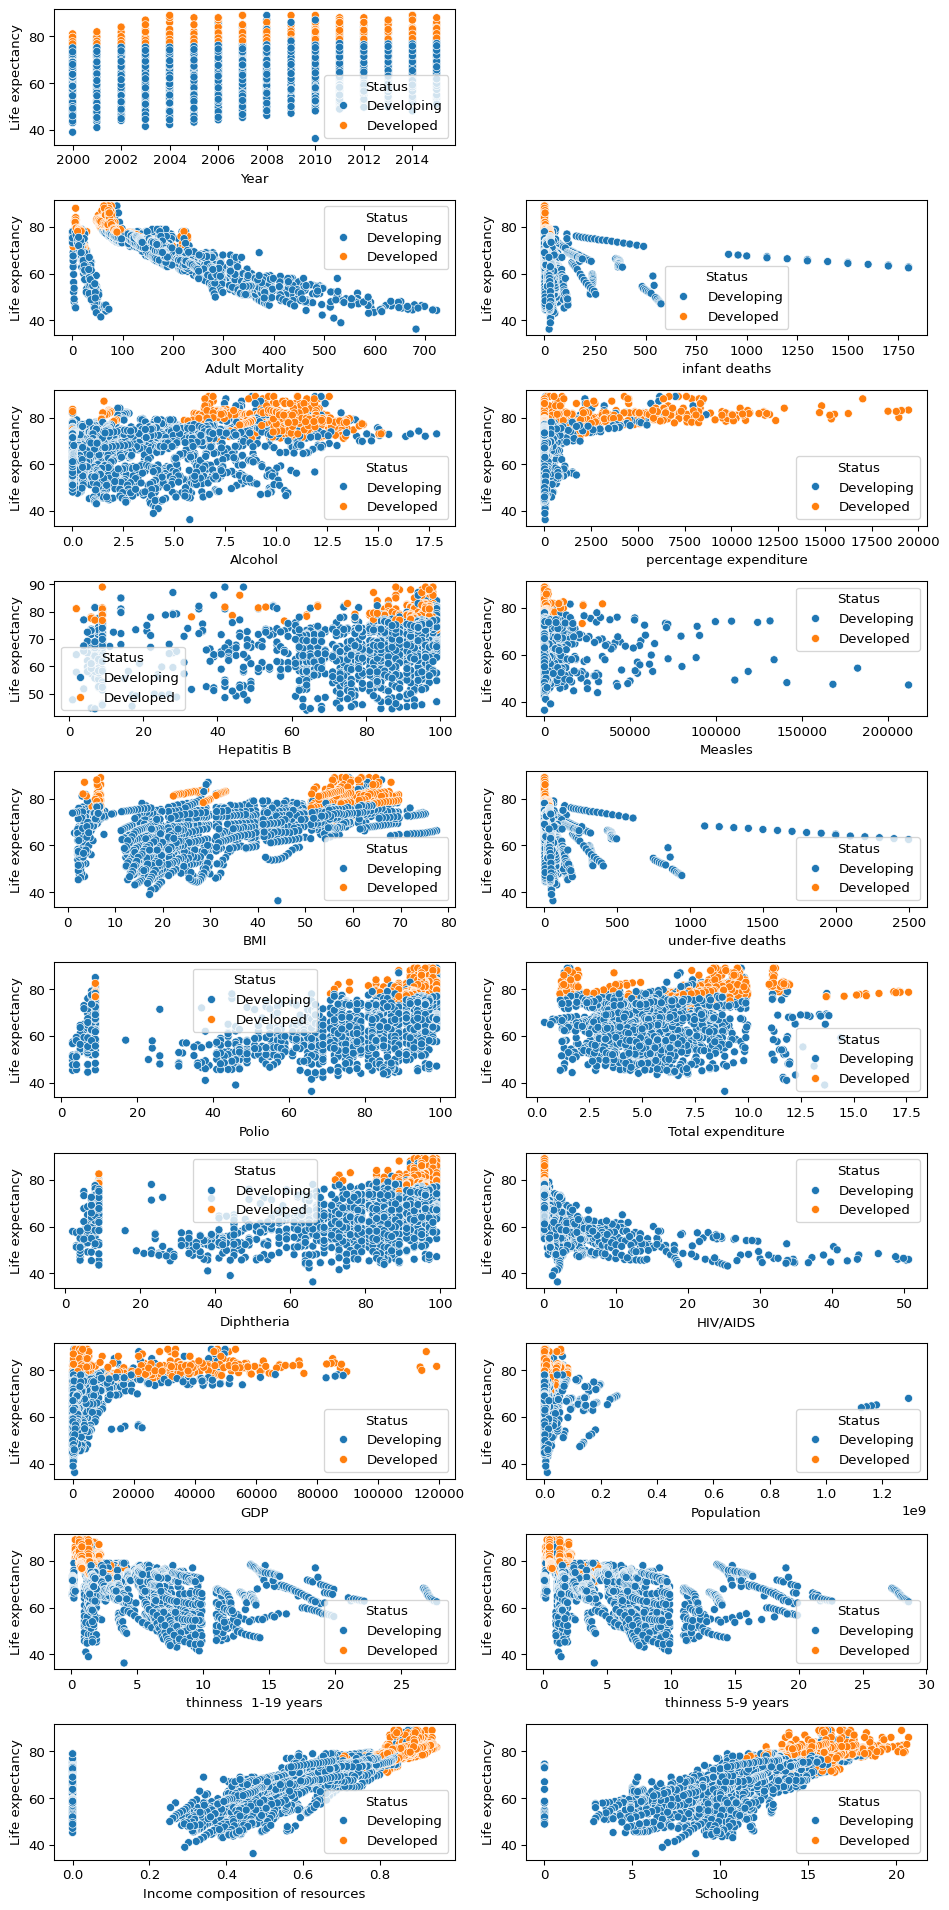

In [5]:
plt.figure(figsize=(10, 20))
for i, col in enumerate(numeric_cols):
    if (col != "Life expectancy"):
        plt.subplot(10, 2, i + 1)
        sns.scatterplot(df, x=col, y="Life expectancy", hue="Status", legend="auto")
plt.tight_layout()
plt.show()

``` {markdown}
Remark:
- State what you see in the chart
- Base on the scatter plot can you spot any variables that seem to have a linear relationship with the target variabel?
```

### Overall statistic

In [6]:
display(df.describe().T)

## Data preprocessing (NAs, outliers, duplicateds, label encoding)

### Missing

In [7]:
print("\nPreprocessing\n")
print(df.isna().sum())
df = df.interpolate(method='linear', limit_direction='forward')
print("\nPostprocessing\n")
print(df.isna().sum())


Preprocessing

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

Postprocessing

Country                            0
Year                               0
Status                

/tmp/ipykernel_50173/365239556.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', limit_direction='forward')

### Duplicated

In [8]:
print(f"Total duplicated values: {df.duplicated().sum()}")

Total duplicated values: 0

### Outliers

#### Detect outliers

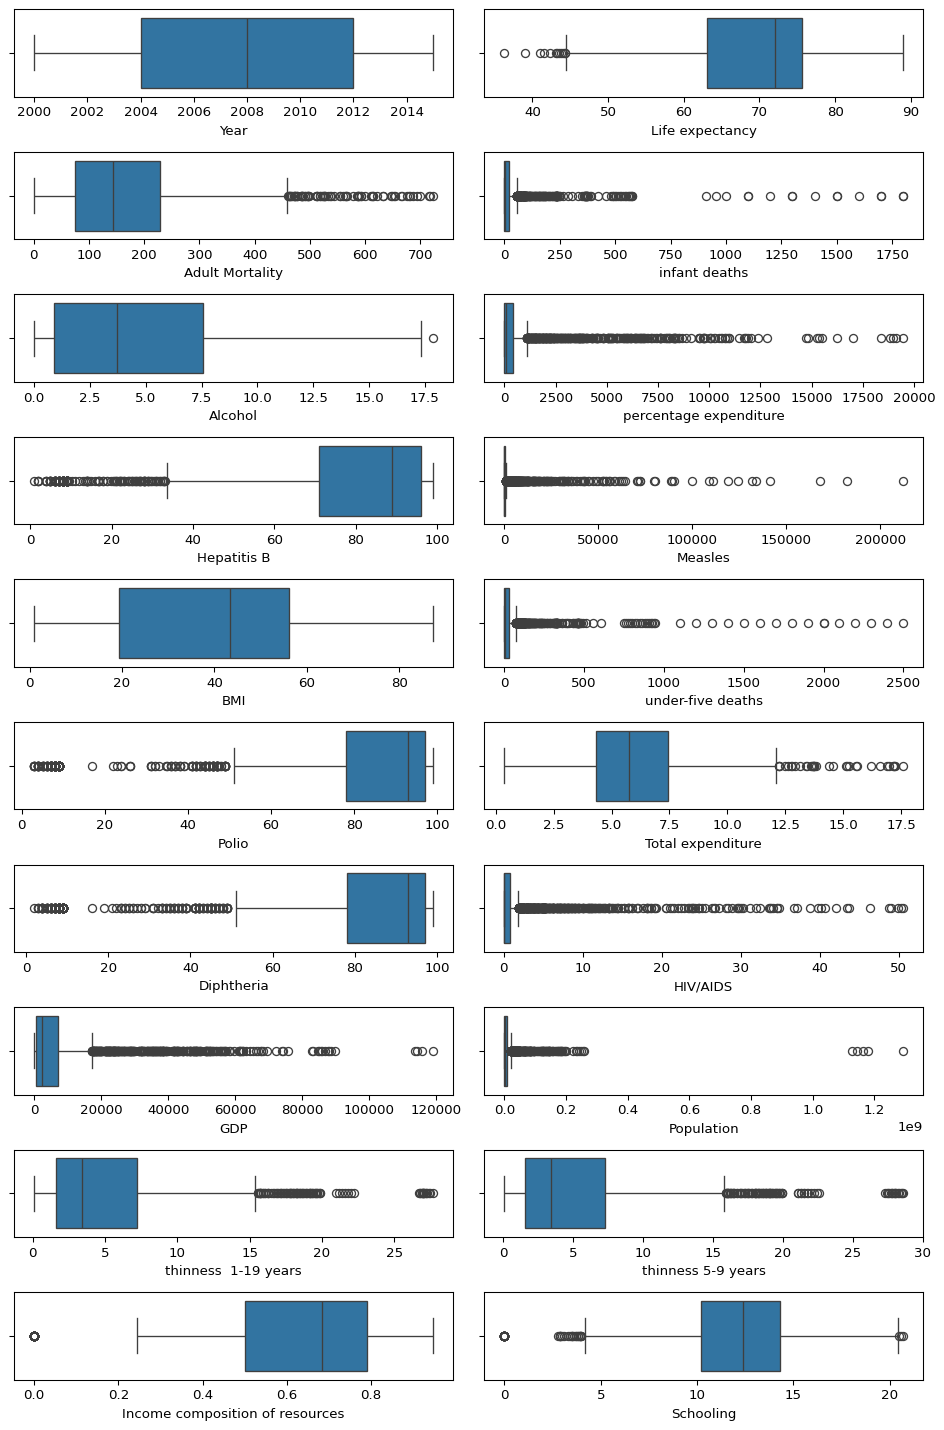

In [9]:
plt.figure(figsize=(10, 15))
for i, col in enumerate(numeric_cols):
    plt.subplot(10, 2, i + 1)
    sns.boxplot(df, x=col)
plt.tight_layout()
plt.show()

# detect outliers
def detectOutliers(data):
    outliers_arr = []
    for col in data.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col].count()
        outliers_arr.append(outliers)
    return pd.DataFrame(outliers_arr, index=data.columns, columns=["Total outliers"])

numeric_data = df.drop(columns=["Status", "Country"], axis=1)
outliers = detectOutliers(numeric_data)
outliers

``` {markdonw}
Why we should not use variable with high outliers -> because regression can heavily be affected by these outliers, hence we should only choose those with low outliers
Potential variable for regression of target
- Year
- Adult Mortality
- Alcohol
- BMI
- Total expenditure
- thinness 1-19 years
- thinness 5-9 years
- Income composition of resources
- Schooling
```

#### Dealing with outliers

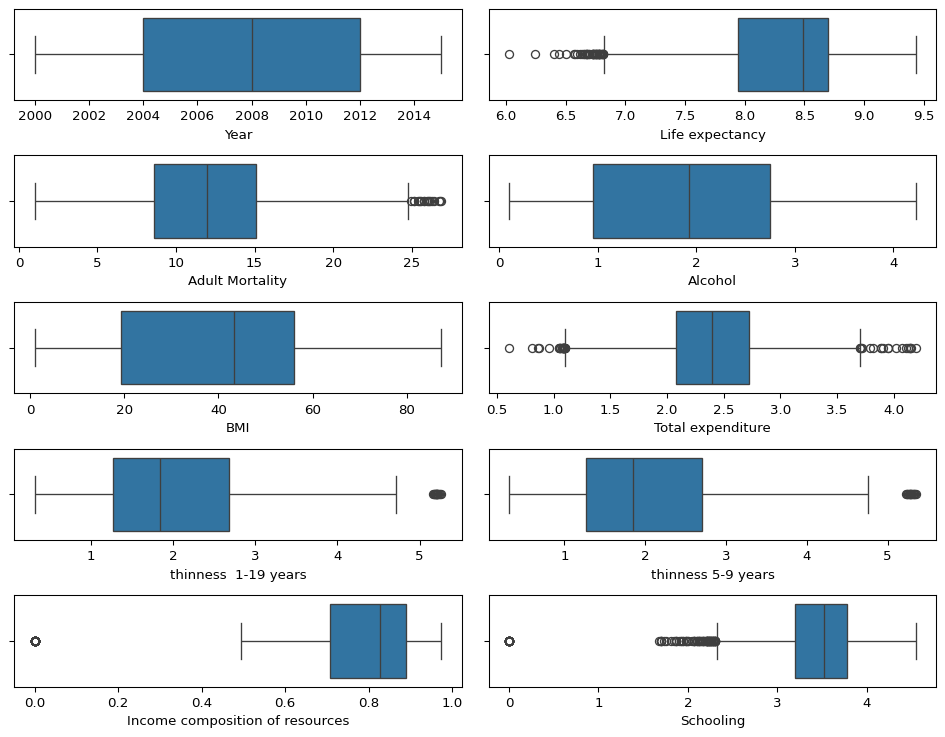

In [10]:
# get potentital variables and variables that have outliers
potential_var = outliers[(outliers["Total outliers"] < 150)].index
outliers_var = outliers[(outliers["Total outliers"] > 0) & (outliers["Total outliers"] < 150)].index

# using transformation to deal with outliers
df_outliers = df.copy()
for col in outliers_var:
    # df_outliers[col] = np.log1p(df_outliers[col])
    df_outliers[col] = np.sqrt(df_outliers[col])

# detect outliers again
numeric_outliers= df_outliers[potential_var]
outliers = detectOutliers(numeric_outliers)
display(outliers)

# plot outliers
plt.figure(figsize=(10, 15))
for i, col in enumerate(potential_var):
    plt.subplot(10, 2, i + 1)
    sns.boxplot(df_outliers, x=col)
plt.tight_layout()
plt.show()

# assign new dataframe to use for regression
df_regress = df_outliers[potential_var]

``` {markdown}
Remark
- Explain reason why we should not use variables that have many outliers
- Explain reason why we choose to use transformation and why is log (or anything else)
- Compare preprocessing and postprocessing
```

### Label encoding

Có cần thiết không?

### Comprare preprocess and postprocess

In [11]:
display(df[potential_var].describe().T)
display(df_regress.describe().T)

``` {markdown}
Remark:
- State what you observe when compare the two tables
```

# Linear Regression Analysis

## Correlation Matrix

### Before dealing with outliers

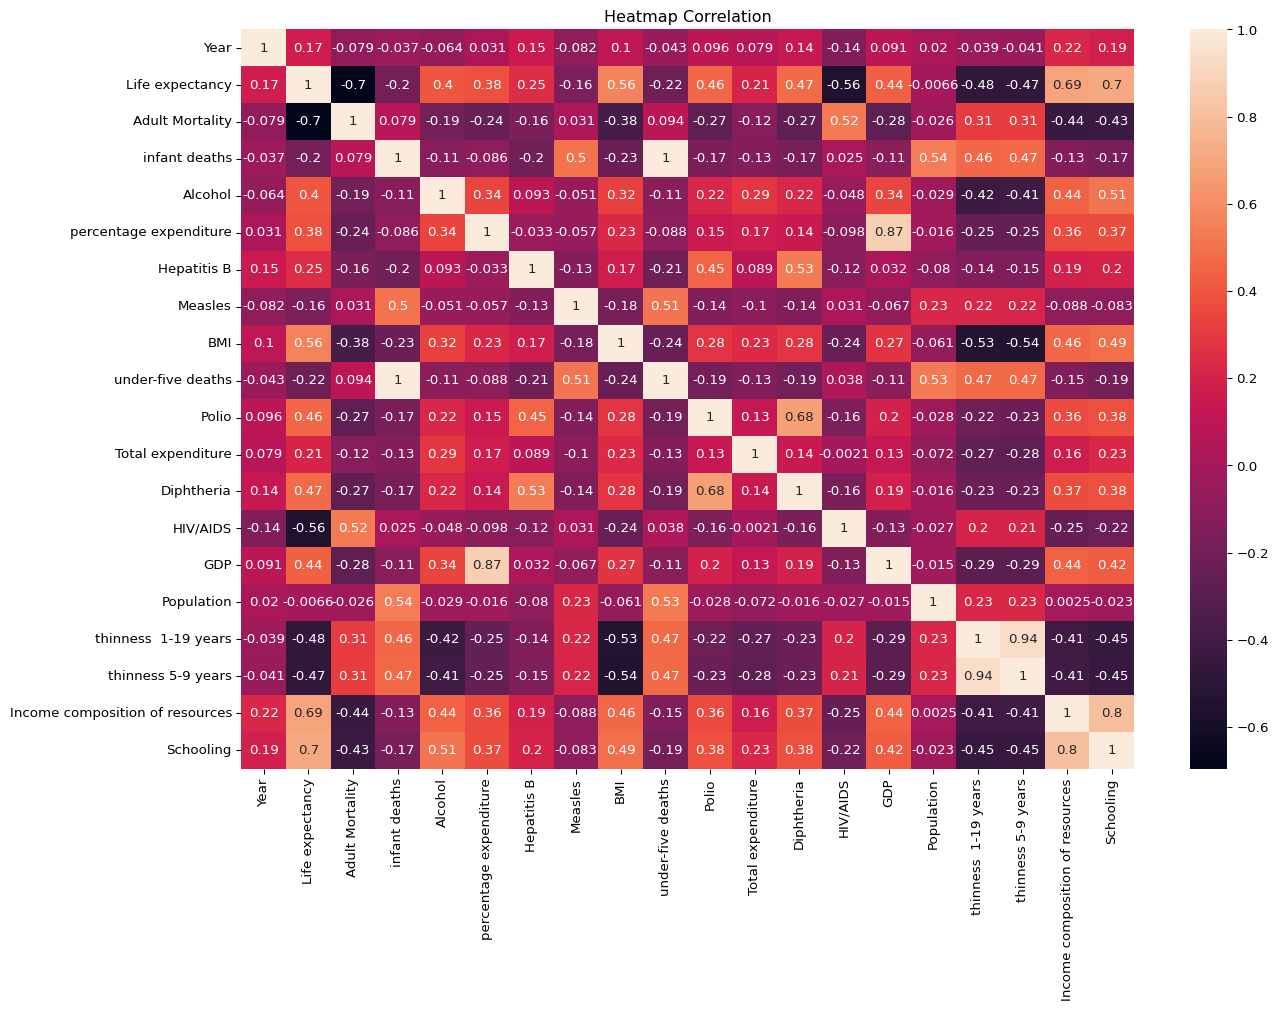

Variables have correlation larger than 0.5: 

Adult Mortality                   -0.6957
BMI                                0.5564
HIV/AIDS                          -0.5559
Income composition of resources    0.6909
Schooling                          0.7043
Name: Life expectancy, dtype: float64

In [12]:
numeric_df = df.drop(columns=["Country", "Status"])
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df.corr(), annot=True)
plt.title('Heatmap Correlation')
plt.show()

# get variables that has high correlation with Life expectancy
corrs = numeric_df.corr()['Life expectancy'].drop('Life expectancy')
high_corr = corrs[corrs.abs() > 0.5]
print("Variables have correlation larger than 0.5: ")
high_corr

### After dealing with outliers

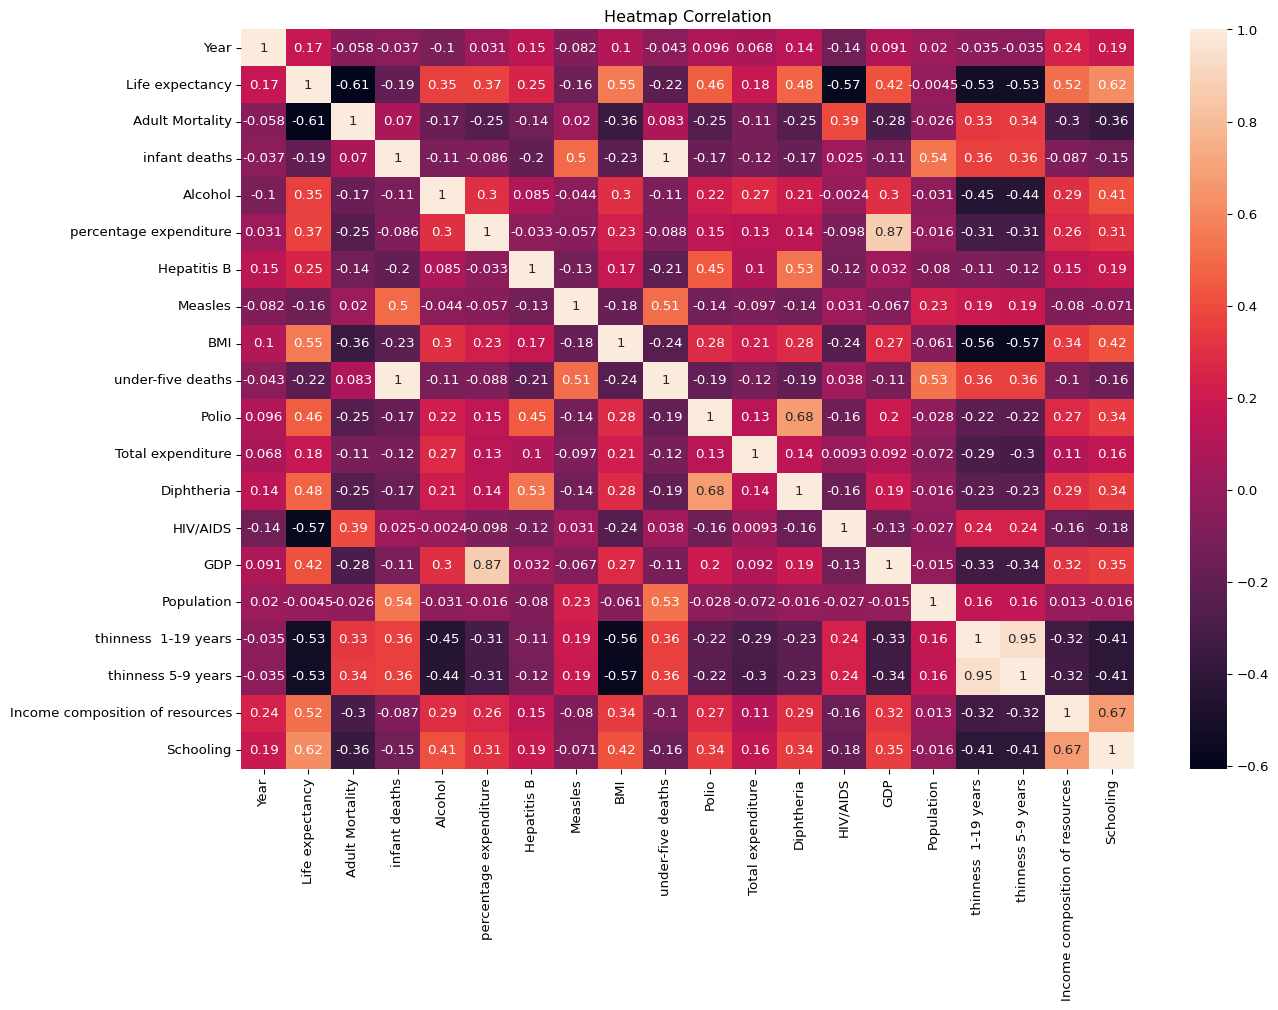

Variables have correlation larger than 0.5: 

Adult Mortality                   -0.6064
BMI                                0.5540
HIV/AIDS                          -0.5715
thinness  1-19 years              -0.5261
thinness 5-9 years                -0.5277
Income composition of resources    0.5161
Schooling                          0.6227
Name: Life expectancy, dtype: float64

In [13]:
numeric_df_outliers = df_outliers.drop(columns=["Country", "Status"])
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df_outliers.corr(), annot=True)
plt.title('Heatmap Correlation')
plt.show()

# get variables that has high correlation with Life expectancy
corrs = numeric_df_outliers.corr()['Life expectancy'].drop('Life expectancy')
high_corr = corrs[corrs.abs() > 0.5]
print("Variables have correlation larger than 0.5: ")
high_corr

``` {markdown}
Remark
- Base on qualitative analysis remark, outliers detection remark, and this correlation matix make the final conclusion on which variable we should use for linear regression of target
- If in outliers dealing part, we use log1p then the chossen are Income composition of resources, and Schooling
- However, if we use sqrt then the chossen are Adult Mortality, and Schooling
```

## Least square regression

``` {markdown}
Remark
```

## Check residuals for at least 4 assumptions